# Project "Data Analysis using Python"

The aim of this project is to demonstrate the process and individual steps of a basic data analysis using Python, including a short excursion into SQL. You can also use it as a tutorial — all steps are clearly demonstrated and explained in detail.

This analysis is conducted using the open-source Sakila database (https://dev.mysql.com/doc/sakila/en/), which contains sales data from a DVD rental store.

## Define the Question / Problem

Does the rental duration and replacement cost of DVDs differ between the rental stores?

## Load Python Libraries

In [1]:
import numpy as np

NumPy is a fundamental package for array computing in Python. Using "as np" introduces an alias name "np" for "numpy" for simplify coding.

In [2]:
import pandas as pd

Pandas are powerful data structures for data analysis, time series, and statistics.
Using "as pd" introduces an alias name "pd" for "pandas" for simplify coding.

In [3]:
from scipy import stats

SciPy are fundamental algorithms for scientific computing in Python

In [4]:
import matplotlib

In [5]:
import matplotlib.pyplot as plt

Matplotlib is a Python plotting package.  
If you only write "import matplotlib", you’re importing the top-level package itself, but not any of its submodules. The syntax import matplotlib.pyplot as plt imports the pyplot submodule of matplotlib and assigns it the shorter alias plt.

In [6]:
import seaborn as sns

Seaborn is a package for statistical data visualization

In [7]:
import sqlite3

SQLite is a database engine

## Import the data

This command opens a connection to the database file using Python's built-in SQLite3 library:

In [8]:
connection = sqlite3.connect("sakila.db")

## Extract the data

One of the most important steps when working with an unfamiliar or large SQL database is to examine which variables are available in the database before writing queries:

In [9]:
cursor = connection.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tabellen = cursor.fetchall()

for t in tabellen:
    print(t[0])

actor
sqlite_sequence
country
city
address
language
category
customer
film
film_actor
film_category
film_text
inventory
staff
store
payment
rental


Choose the relevant variables, join the corresponding tables from the Sakila database, and create the final dataset:

In [10]:
df = pd.read_sql('''
    SELECT
        rental.rental_id,
        customer.last_name AS name_customer,
        store.store_id,
        city.city,
        film.title AS film_title,
        film.rental_duration AS film_rental_duration,
        film.replacement_cost AS film_replacement_cost
    FROM rental
    INNER JOIN customer ON rental.customer_id == customer.customer_id
    INNER JOIN inventory ON rental.inventory_id == inventory.inventory_id
    INNER JOIN store ON inventory.store_id == store.store_id
    INNER JOIN address ON store.address_id == address.address_id
    INNER JOIN city ON address.city_id == city.city_id
    INNER JOIN film ON inventory.film_id == film.film_id
    ;
''', connection, index_col='rental_id')

Check that data was loaded correctly by returning the first five rows of the DataFrame:

In [11]:
df.head()

,name_customer,store_id,city,film_title,film_rental_duration,film_replacement_cost
rental_id,,,,,,
1,HUNTER,1,Lethbridge,BLANKET BEVERLY,7,21.99
2,COLLAZO,2,Woodridge,FREAKY POCUS,7,16.99
3,MURRELL,2,Woodridge,GRADUATE LORD,7,14.99
4,PURDY,1,Lethbridge,LOVE SUICIDES,6,21.99
5,HANSEN,2,Woodridge,IDOLS SNATCHERS,5,29.99


## Clean the data

Compute missing values:

In [12]:
pd.isnull(df).sum()

name_customer            0
store_id                 0
city                     0
film_title               0
film_rental_duration     0
film_replacement_cost    0
dtype: int64

This command returns the number of missing values per column.  
Result: There are no missing values in the data.

Detect outliers for the variable replacement cost:

In [13]:
z_scores = np.abs(stats.zscore(df["film_replacement_cost"]))
outliers = df["film_replacement_cost"][z_scores > 3]
print(z_scores)
print(outliers)

[0.29179209 0.53036243 0.85922424 ... 0.69479333 1.44280841 0.9495157 ]
Series([], Name: film_replacement_cost, dtype: float64)


Interpretation of the result:  
In the first output line, you see an array of Z-scores. A Z-score indicates how many standard deviations a value is away from the mean.  
- Z-score of 0 → the value lies exactly at the mean.
- Z-score of 1.0 → the value is one standard deviation above the mean.
- Z-score of –1.0 → one standard deviation below the mean.

Typically, values with ∣z∣ > 3 are considered outliers.  
The second output line means that no values were found with a Z-score greater than 3, i.e. no outliers according to the 3-sigma rule (three-standard-deviation criterion).

Conclusion:  
The replacement cost values all lie within the normal range (maximum deviation about ~1.44 standard deviations from the mean). Therefore, this column in the dataset is well distributed and contains no extreme outliers.

Detect outliers for the variable rental duration:

In [14]:
z_scores = np.abs(stats.zscore(df["film_rental_duration"]))
outliers = df["film_rental_duration"][z_scores > 3]
print(z_scores)
print(outliers)

[1.47291822 1.47291822 1.47291822 ... 0.66742232 0.66742232 0.66742232]
Series([], Name: film_rental_duration, dtype: int64)


Conclusion:
The rental duration values all lie within the normal range (maximum deviation about ~1.47 standard deviations from the mean). Therefore, this column in the dataset is well distributed and contains no extreme outliers.

## Explore the data

Goal: Understand the structure, patterns, and relationships in the data.

Size of the dataset (numer of rows and columns):

In [15]:
df.shape

(16044, 6)

Computing summary statistics (mean value, standard deviation, minimum and maximum value):

In [16]:
df.describe()

,store_id,film_rental_duration,film_replacement_cost
count,16044.000000,16044.00000,16044.000000
mean,1.506171,4.93549,20.215443
std,0.499978,1.40169,6.081771
min,1.000000,3.00000,9.990000
25%,1.000000,4.00000,14.990000
50%,2.000000,5.00000,20.990000
75%,2.000000,6.00000,25.990000
max,2.000000,7.00000,29.990000


Visualize the data of replacement cost using the Python library Seaborn:

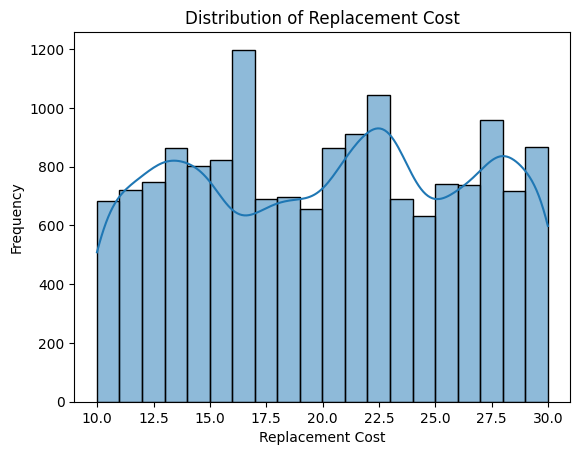

In [17]:
sns.histplot(df["film_replacement_cost"], bins=20, kde=True)
plt.title("Distribution of Replacement Cost")
plt.xlabel("Replacement Cost")
plt.ylabel("Frequency")
plt.show()

Visualize the data of rental duration using the Python library Matplotlib:

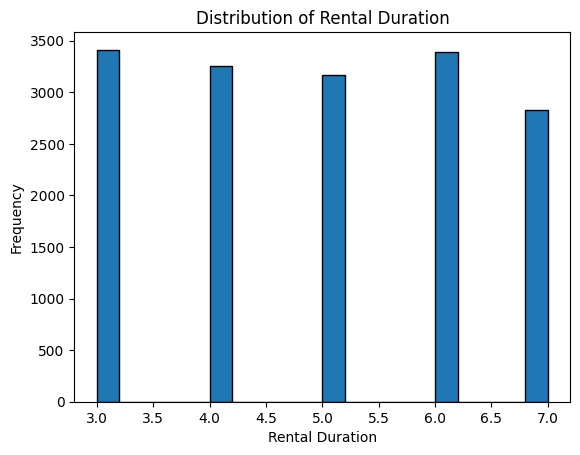

In [18]:
plt.hist(df["film_rental_duration"], bins=20, edgecolor="black")
plt.title("Distribution of Rental Duration")
plt.xlabel("Rental Duration")
plt.ylabel("Frequency")
plt.show()

## Analyze the Data

Question: "Does the rental duration and replacement cost of DVDs differ between the rental stores?"

Goal: Test if the medians of these numeric variables differ between groups.

Dependent variables: rental duration, replacement cost (both numeric)  
Independent variable: store (categorical; 2 stores)

Statistical approach:  
The data are not normally distributed, so the assumptions for standard ANOVA are violated. Therefore, a non-parametric test should be used. In this case, the Mann–Whitney U test is appropriate, as it is designed for comparing two independent groups with non-normal data. This test evaluates whether the medians of the two groups differ significantly.

Mann-Whitney U test for the variable "rental duration":

Null hypothesis (H₀): The distributions (medians) of rental duration are the same in the two stores.  
Alternative hypothesis (H₁): The distributions (medians) differ between the stores.

In [19]:
from scipy.stats import mannwhitneyu

# split the data
store1_duration = df[df['store_id']==1]['film_rental_duration']
store2_duration = df[df['store_id']==2]['film_rental_duration']

# Mann-Whitney U test
stat, p = mannwhitneyu(store1_duration, store2_duration, alternative='two-sided')
print("U-Statistic:", stat)
print("p-value:", p)

U-Statistic: 31714787.5
p-value: 0.11204343265791486


Our p-value = 0.112  
Common significance level: α = 0.05  
Since 0.112 > 0.05, we do not reject the null hypothesis.  
Interpretation: There is no statistically significant difference in rental duration between the two stores.

Validate the test results by comparing medians:

In [20]:
median_duration_per_store = df.groupby("store_id")["film_rental_duration"].median()

print(median_duration_per_store)

store_id
1    5.0
2    5.0
Name: film_rental_duration, dtype: float64


Visualizing the rental duration per store using a boxplot:

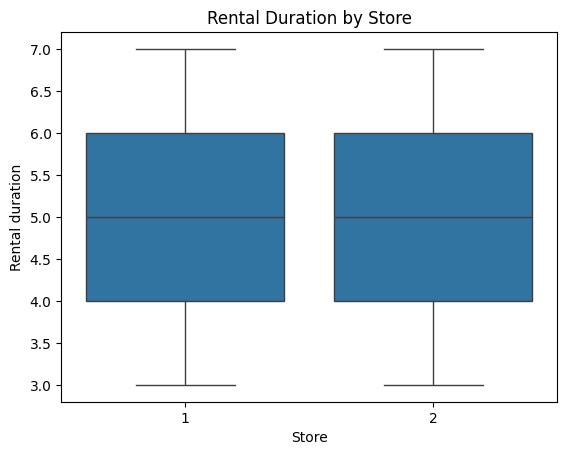

In [21]:
sns.boxplot(data=df, x='store_id', y='film_rental_duration')
plt.title("Rental Duration by Store")
plt.xlabel("Store")
plt.ylabel("Rental duration")
plt.show()

The median rental duration in Store 1 was 5 days, compared to 5 days in Store 2.  
The Mann–Whitney U test indicated that this difference was not statistically significant (p = 0.112).

Mann-Whitney U test for the variable "replacement cost":

Null hypothesis (H₀): The distributions (medians) of replacement cost are the same in the two stores.  
Alternative hypothesis (H₁): The distributions (medians) differ between the stores.

In [22]:
# split the data
store1_cost = df[df['store_id']==1]['film_replacement_cost']
store2_cost = df[df['store_id']==2]['film_replacement_cost']

# Mann-Whitney U test
stat, p = mannwhitneyu(store1_cost, store2_cost, alternative='two-sided')
print("U-Statistic:", stat)
print("p-value:", p)

U-Statistic: 32976041.5
p-value: 0.006017219696486957


Our p-value = 0.006  
Common significance level: α = 0.05  
Since 0.006 < 0.05, we reject the null hypothesis.  
Interpretation: There is a statistically significant difference between the two stores in terms of replacement cost.

Validate the test results by comparing medians:

In [23]:
median_cost_per_store = df.groupby("store_id")["film_replacement_cost"].median()

print(median_cost_per_store)

store_id
1    20.99
2    19.99
Name: film_replacement_cost, dtype: float64


Visualizing the replacement cost per store using a boxplot:

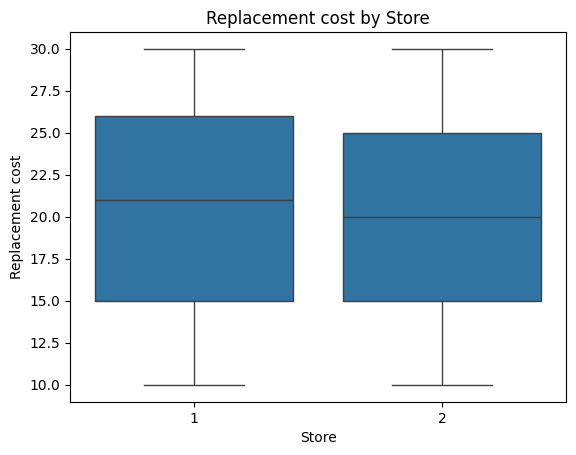

In [24]:
sns.boxplot(data=df, x='store_id', y='film_replacement_cost')
plt.title("Replacement cost by Store")
plt.xlabel("Store")
plt.ylabel("Replacement cost")
plt.show()

The median replacement cost in Store 1 was 20.99 USD, compared to 19.99 USD in Store 2.  
The Mann–Whitney U test indicated that this difference was statistically significant (p = 0.006).

## Interpret the Results

The analysis examined whether rental duration and replacement cost of DVDs differ between the two rental stores.  
A Mann–Whitney U test was used because the data were not normally distributed:

For rental duration, the test showed no statistically significant difference between the two stores (p = 0.112).  
Conclusion: This means that customers in both stores tend to rent DVDs for about the same length of time.

For replacement cost, the test showed a statistically significant difference between the stores (p = 0.006).  
Conclusion: This indicates that the DVDs offered in one store are, on average, more expensive to replace than those in the other store. In other words, the two stores differ in the value of their DVD collections — one carries higher-cost titles than the other.

## The End

In [25]:
connection.close()

This command closes the connection between the Python program and the database we previously opened.